# Modules Imports

In [1]:
import os
import time
import pandas as pd
import shap

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.types import FloatType, ArrayType

from pyspark.ml.classification import GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import  BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, VectorIndexer, OneHotEncoder, StringIndexer, StandardScaler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.functions import vector_to_array
from pyspark.ml.pipeline import Transformer
from pyspark import keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param, Params, TypeConverters
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# visualization customization
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [20, 7]

---
# Data Importation & Preprocessing

In [2]:
spark = SparkSession \
    .builder \
    .appName("Pipeline_model") \
    .getOrCreate()

spark.sparkContext.setLogLevel('OFF')

22/02/22 16:18:21 WARN Utils: Your hostname, Sams-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.48 instead (on interface en0)
22/02/22 16:18:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/02/22 16:18:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/22 16:18:23 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/02/22 16:18:23 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/02/22 16:18:23 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [3]:
df = spark.sql("SELECT * FROM parquet.`data/complete_df.parquet`")

In [4]:
df.printSchema()

root
 |-- account_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- contract_start_date: string (nullable = true)
 |-- contract_end_date: string (nullable = true)
 |-- tenure: double (nullable = true)
 |-- account_type: string (nullable = true)
 |-- contract_type: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- country: string (nullable = true)
 |-- recurrence: string (nullable = true)
 |-- opt_out: boolean (nullable = true)
 |-- opt_out_exercised: boolean (nullable = true)
 |-- company_type: string (nullable = true)
 |-- billing_bucket: double (nullable = true)
 |-- matches: integer (nullable = true)
 |-- infringements: integer (nullable = true)
 |-- takedowns: integer (nullable = true)
 |-- closed: integer (nullable = true)
 |-- isChurn: integer (nullable = true)



In [5]:
class DropColumns(Transformer, HasInputCol, DefaultParamsReadable, DefaultParamsWritable):
    input_cols = Param(Params._dummy(), 'input_cols', 'input column names', typeConverter=TypeConverters.toList)

    @keyword_only
    def __init__(self, input_cols: list = 'input'):
        super(DropColumns, self).__init__()
        self._setDefault(input_cols=None)
        kwargs = self._input_kwargs
        self.set_params(**kwargs)

    @keyword_only
    def set_params(self, input_cols: list = 'input'):
        kwargs = self._input_kwargs
        self._set(**kwargs)

    def get_input_cols(self):
        return self.getOrDefault(self.input_cols)

    def _transform(self, df: DataFrame):
        input_cols = self.get_input_cols()
        return df.drop(*[column for column in input_cols])

In [6]:
class OptOutIndexer(Transformer, HasInputCol, HasOutputCol, DefaultParamsReadable, DefaultParamsWritable):
    input_cols = Param(Params._dummy(), 'input_cols', 'input column names', typeConverter=TypeConverters.toList)
    output_cols = Param(Params._dummy(), 'output_cols', 'output column names', typeConverter=TypeConverters.toList)

    @keyword_only
    def __init__(self, input_cols: list = 'input', output_cols: list = 'output'):
        super(OptOutIndexer, self).__init__()
        self._setDefault(input_cols=None, output_cols=None)
        kwargs = self._input_kwargs
        self.set_params(**kwargs)

    @keyword_only
    def set_params(self, input_cols: list = 'input', output_cols: list = 'output'):
        kwargs = self._input_kwargs
        self._set(**kwargs)

    def get_input_cols(self):
        return self.getOrDefault(self.input_cols)

    def get_output_cols(self):
        return self.getOrDefault(self.output_cols)

    def _transform(self, df: DataFrame):
        input_cols = self.get_input_cols()
        output_cols = self.get_output_cols()
        return df.withColumn(
            output_cols[0],
            when(
                col(input_cols[0]) == 'true', 1
            ).otherwise(0)
        ).withColumn(
            output_cols[1],
            when(
                col(input_cols[1]) == 'true', 1
            ).otherwise(0)
        )

In [7]:
df = df.withColumn('rank', percent_rank().over(Window.partitionBy().orderBy('date')))

train = df.where('rank <= .8').drop('rank', 'date')
test = df.where('rank > .8').drop('rank', 'date')

In [8]:
indexer = StringIndexer(
    inputCols=['contract_type', 'industry', 'country', 'company_type',  'recurrence'],
    outputCols=['contract_types', 'industries', 'countries', 'company_types',  'recurrences']
)

indexer = indexer.fit(train)

opt_outs_transformer = OptOutIndexer(input_cols=['opt_out', 'opt_out_exercised'], output_cols=['opt_out_t', 'opt_out_exercised_t'])
col_drop_transformer = DropColumns(input_cols=['contract_type', 'industry', 'country', 'company_type',  'recurrence'])

columns = ['tenure', 'contract_types', 'industries', 'recurrences', 'opt_out', 'opt_out_exercised', 'company_types','matches', 'infringements', 'takedowns', 'closed', 'billing_bucket']  # 'country'

assembler = VectorAssembler(inputCols=columns, outputCol='_features').setHandleInvalid('skip')
scaler = StandardScaler(inputCol='_features' , outputCol='features')

In [9]:
rf_model = RandomForestClassifier(
    maxDepth=5,
    numTrees=5,
    labelCol='isChurn'
)

In [10]:
stages = [opt_outs_transformer, indexer, col_drop_transformer, assembler, scaler, rf_model]

pipe = Pipeline(stages=stages)

model = pipe.fit(train)
prediction = model.transform(test)
# model_df = model_df.select('date', 'account_id', 'features', col('isChurn').alias('label'))

In [11]:
prediction.printSchema()

root
 |-- account_id: string (nullable = true)
 |-- contract_start_date: string (nullable = true)
 |-- contract_end_date: string (nullable = true)
 |-- tenure: double (nullable = true)
 |-- account_type: string (nullable = true)
 |-- opt_out: boolean (nullable = true)
 |-- opt_out_exercised: boolean (nullable = true)
 |-- billing_bucket: double (nullable = true)
 |-- matches: integer (nullable = true)
 |-- infringements: integer (nullable = true)
 |-- takedowns: integer (nullable = true)
 |-- closed: integer (nullable = true)
 |-- isChurn: integer (nullable = true)
 |-- opt_out_t: integer (nullable = false)
 |-- opt_out_exercised_t: integer (nullable = false)
 |-- recurrences: double (nullable = false)
 |-- industries: double (nullable = false)
 |-- contract_types: double (nullable = false)
 |-- countries: double (nullable = false)
 |-- company_types: double (nullable = false)
 |-- _features: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (n

In [12]:
prediction.select(
    'account_id', 'probability', 'prediction', 'isChurn'
).withColumn('probability', round(array_max(vector_to_array('probability')), 2)).show(10, False)

+---------------+-----------+----------+-------+
|account_id     |probability|prediction|isChurn|
+---------------+-----------+----------+-------+
|0011n00001vVDsy|0.93       |0.0       |0      |
|0011n00001xVkPa|0.59       |0.0       |0      |
|0011n00001xVkPa|0.59       |0.0       |0      |
|0011n0000259Ozz|0.93       |0.0       |0      |
|0011n0000259MXR|0.89       |0.0       |0      |
|0010Y00001YPsZx|0.93       |0.0       |0      |
|0011n000026QyzW|0.86       |0.0       |0      |
|0011n00001iasIc|0.95       |1.0       |1      |
|0011n00002ZugA7|1.0        |1.0       |1      |
|0011n0000259LTH|0.74       |0.0       |1      |
+---------------+-----------+----------+-------+
only showing top 10 rows



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'recurrences'),
  Text(1, 0, 'tenure'),
  Text(2, 0, 'billing_bucket'),
  Text(3, 0, 'opt_out_exercised'),
  Text(4, 0, 'contract_types'),
  Text(5, 0, 'opt_out'),
  Text(6, 0, 'industries'),
  Text(7, 0, 'company_types'),
  Text(8, 0, 'closed'),
  Text(9, 0, 'matches'),
  Text(10, 0, 'takedowns'),
  Text(11, 0, 'infringements')])

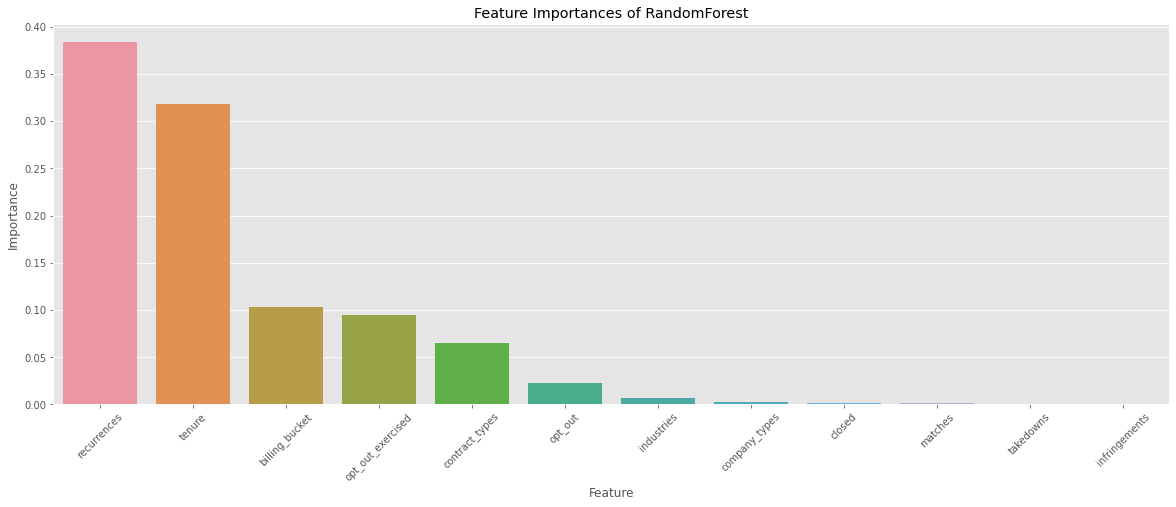

In [13]:
feat_importance = pd.DataFrame(
    list(
        zip(columns, model.stages[-1].featureImportances)
    ),
    columns= ['Feature', 'Importance']
)

plt.title('Feature Importances of RandomForest')
sns.barplot(
    x='Feature',
    y='Importance',
    data=feat_importance.sort_values(by='Importance', ascending=False).iloc[:16])
plt.xticks(rotation=45)

#Model Evaluation
evaluator= BinaryClassificationEvaluator(labelCol='isChurn')

areaUnderROC = evaluator.evaluate(prediction.select('account_id', 'rawPrediction', 'probability', 'prediction', 'isChurn').drop_duplicates(['account_id']), {evaluator.metricName: 'areaUnderROC'})
areaUnderROC = evaluator.evaluate(prediction.select('account_id', 'rawPrediction', 'probability', 'prediction', 'isChurn').drop_duplicates(['account_id']), {evaluator.metricName: 'areaUnderROC'})

In [14]:
model.write().overwrite().save('./model_export')